## Main notebook for the preprocessing-sorting-postprocessing pipeline with SpikeInterface

### Imports

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import spikeinterface.full as si
from probeinterface import read_probeinterface
from probeinterface.plotting import plot_probe
from adc_shifts import adc_shifts

%matplotlib widget

### Set pipeline parameters

In [29]:
pipeline_info_dict = {}

In [89]:
# Data loading
num_channels = 384
sampling_frequency = 2500
# see this thread https://community.brain-map.org/t/using-the-raw-data/1898 for gain scaling factor and dtype
gain_recording =4.69
offset_recording = 0
dtype = np.int16

pipeline_info_dict.update({'num_channels': num_channels, 'sampling_frequency': sampling_frequency, 'gain_recording': gain_recording, 'offset_recording': offset_recording, 'dtype': dtype})

In [105]:
# Preprocessing and sorting
highpass_frequency = 1 # Hz

sorter_name = 'kilosort3'
sorter_path = Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images' / f'{sorter_name}-compiled-base-sandbox'
output_folder = Path.home() / 'RANCZLAB-NAS/output_sorter/mouse_343'
remove_existing_folder = True

pipeline_info_dict.update({'sorter_name': sorter_name, 'sorter_path': sorter_path, 'output_folder': output_folder, 'remove_existing_folder': remove_existing_folder})

In [106]:
# Other
backend = 'ipywidgets'

pipeline_info_dict.update({'backend': backend})

### Loading the data

#### Reading the binary file

In [107]:
# Main working directory
base_folder = Path.home() / 'RANCZLAB-NAS/data/ONIX/mouse_343/mouse_343_2024-06-13T133909Z'

# Input data
binary_filename = 'LFP.bin'

# # Output sorting
# output_folder = base_folder / 'kilosort3_sorting_files'
# sorting_save_path = base_folder / 'kilosort3_sorting_output'

pipeline_info_dict.update({'data_path': base_folder, 'binary_filename': binary_filename})

In [108]:
os.listdir(base_folder)

['SpikeData.bin',
 'LFP.bin',
 'Clock.bin',
 'CurrentPosition.csv',
 'FrameCounter.bin']

In [109]:
recordings = {}
recordings['raw'] = si.read_binary(base_folder / binary_filename, sampling_frequency=sampling_frequency, dtype=dtype, num_channels=num_channels, gain_to_uV=1.0, offset_to_uV=0)
recordings['raw'] = si.scale(recordings['raw'], gain=gain_recording, offset=offset_recording) #scale to uV
recordings['raw']

ScaleRecording: 384 channels - 2.5kHz - 1 segments - 382,506 samples - 153.00s (2.55 minutes) 
                float32 dtype - 560.31 MiB

#### Attaching the probe configuration

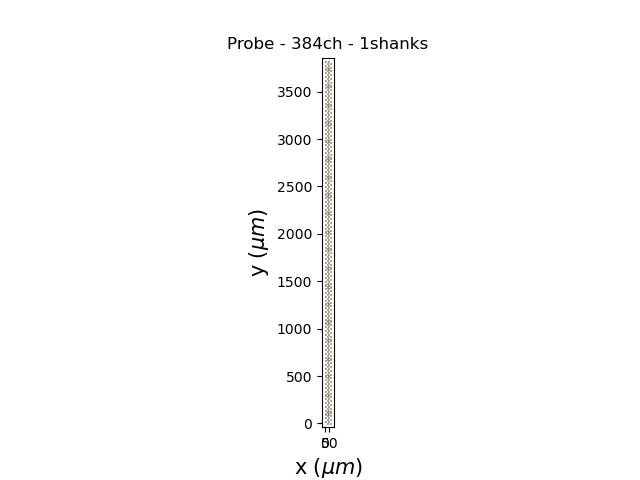

In [110]:
probegroup = read_probeinterface('np_json_files/np1.json')
probe = probegroup.probes[0]
recordings['raw'] = recordings['raw'].set_probe(probe)

plot_probe(probe)
plt.show()

### Preprocessing

In [111]:
# perform the phase shift (similar to IBL destriping or `tshift` option in CatGT):
recordings['phase_shift'] = si.phase_shift(recordings['raw'], inter_sample_shift=adc_shifts()[0])

In [112]:
# # detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = si.detect_bad_channels(recordings['phase_shift'])
recordings['good_channels'] = recordings['phase_shift'].remove_channels(remove_channel_ids=bad_channel_ids)

pipeline_info_dict.update({'channel_labels': channel_labels, 'bad_channel_ids': bad_channel_ids})

In [98]:
print('Channels removed:', {k: channel_labels[k] for k in bad_channel_ids})

Channels removed: {9: 'noise', 11: 'noise', 13: 'noise', 19: 'noise', 23: 'noise', 26: 'noise', 38: 'noise', 40: 'noise', 41: 'noise', 42: 'noise', 43: 'noise', 45: 'noise', 48: 'noise', 51: 'noise', 55: 'noise', 61: 'noise', 68: 'noise', 69: 'noise', 70: 'noise', 71: 'noise', 91: 'noise', 98: 'noise', 101: 'noise', 102: 'noise', 103: 'noise', 105: 'noise', 112: 'noise', 117: 'noise', 126: 'noise', 133: 'noise', 155: 'noise', 158: 'noise', 164: 'noise', 177: 'noise', 179: 'noise', 187: 'dead', 194: 'noise', 195: 'noise', 201: 'noise', 214: 'noise', 222: 'noise', 233: 'noise', 244: 'noise', 246: 'noise', 248: 'noise', 316: 'noise', 345: 'noise', 355: 'noise', 369: 'noise', 374: 'noise', 375: 'noise', 376: 'noise'}


In [113]:
recordings['highpass'] = si.highpass_filter(recordings['phase_shift'], freq_min=highpass_frequency)

In [114]:
# subtract the median across all channels
recordings['common_reference'] = si.common_reference(recordings['highpass'], operator="median", reference="global")

In [101]:
parameter_dict = si.get_default_sorter_params(sorter_name)

In [102]:
parameter_dict['projection_threshold'] = [10, 4]
parameter_dict['freq_min'] = 150
parameter_dict['minfr_goodchannels'] = 0.1
parameter_dict['freq_min'] = highpass_frequency
# parameter_dict['lam'] = 10 # default value already
parameter_dict['AUCsplit'] = 0.9
parameter_dict['minFR'] = 1/50
# parameter_dict['momentum'] = [20, 400] # default value already
parameter_dict['sigmaMask'] = 30
parameter_dict['preclust_threshold'] = 8
parameter_dict['skip_kilosort_preprocessing'] = False

# parameter_dict['scaleproc'] = 200

parameter_dict['n_jobs'] = -1

pipeline_info_dict.update({'parameter_dict': parameter_dict})

In [103]:
print(parameter_dict)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.02, 'minfr_goodchannels': 0.1, 'nblocks': 5, 'sig': 20, 'freq_min': 3, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'do_correction': True, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': -1, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


### Plot raster

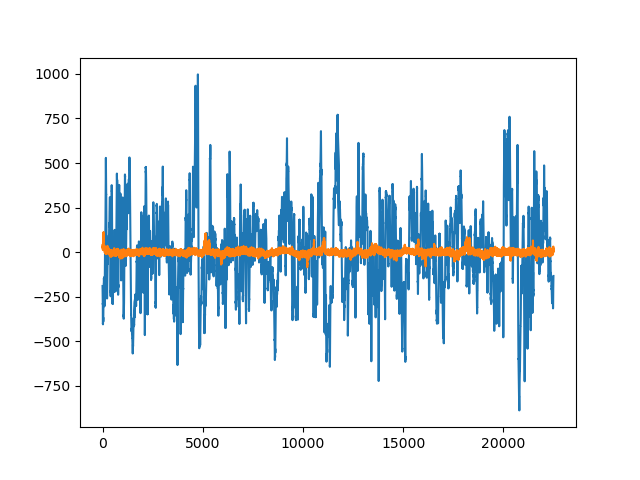

In [141]:
 %matplotlib notebook
trace = recordings['common_reference'].get_traces(channel_ids=[50, 300], start_frame=2500, end_frame=2500*1)
plt.figure()
plt.plot(trace[:,0])
plt.plot(trace[:,1])
#plt.plot(trace[:,2])
#plt.plot(trace[:,3])
plt.show()

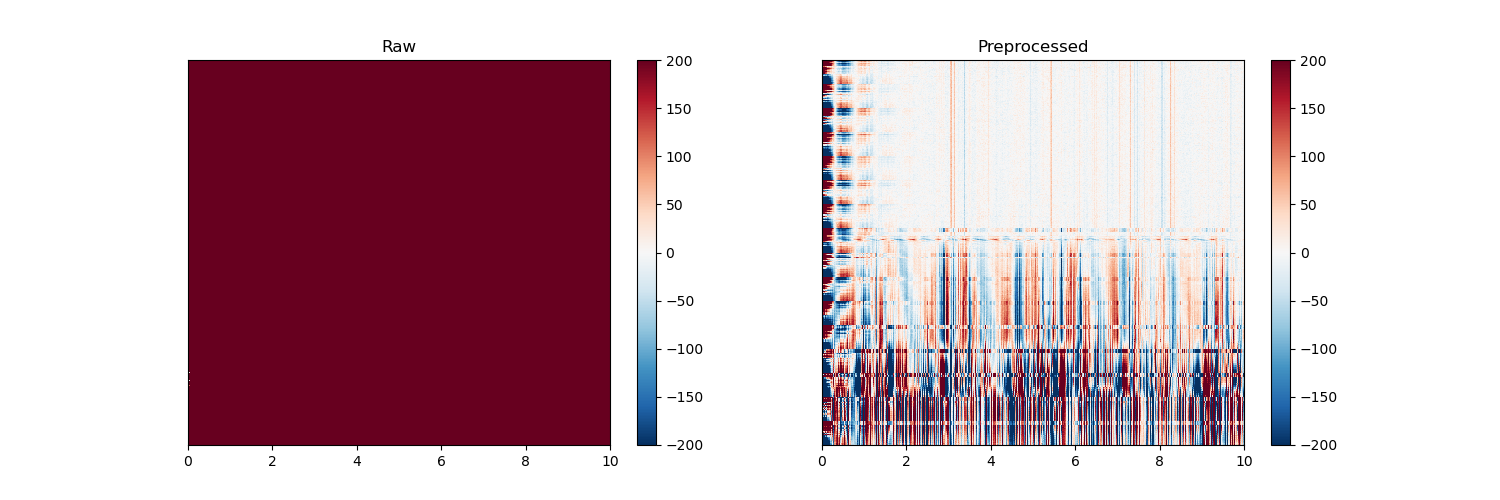

In [142]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].set_title('Raw')
si.plot_traces(recordings['raw'], mode='map', time_range=[0, 10], backend='matplotlib', ax=ax[0])
ax[1].set_title('Preprocessed')
si.plot_traces(recordings['common_reference'], mode='map', time_range=[0, 10], backend='matplotlib', ax=ax[1])
plt.show()

In [138]:
recordings.keys()

dict_keys(['raw', 'phase_shift', 'good_channels', 'highpass', 'common_reference'])

In [21]:
si.plot_traces(recordings['highpass'], mode='map', time_range=[0, 10], backend=backend, height_cm=25, width_cm=60)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Save pipeline information into json file

In [22]:
with open(output_folder/'pipeline_info.json', 'w') as fp:
    json.dump(pipeline_info_dict, fp)

TypeError: Object of type type is not JSON serializable

### Run sorting

In [23]:
sorting = si.read_sorter_folder(output_folder)
sorting

Exception: This folder /home/jupyter-nora/RANCZLAB-NAS/output_sorter/mouse_343 does not have spikeinterface_log.json

In [26]:
sorting = si.run_sorter(sorter_name, recording=recordings['common_reference'], output_folder=output_folder, singularity_image=sorter_path, verbose=True, remove_existing_folder=remove_existing_folder, **parameter_dict)
sorting.save(folder=output_folder/'si_save', format='npz_folder', **parameter_dict)

AssertionError: The container requires a NVIDIA GPU capability, but it is not available

### Postprocessing / exporting

In [ ]:
sorting

In [ ]:
# the waveforms are sparse so it is faster to export to phy
we = si.extract_waveforms(recording=recordings['preprocessed'], sorting=sorting, folder='waveforms', unit_batch_size=800)

# compute some metrics needed for this module:
spike_amplitudes = si.compute_spike_amplitudes(waveform_extractor=we)
principal_components = si.compute_principal_components(waveform_extractor=we,
                                 n_components=5,
                                 mode='by_channel_global')

# save the data in a specified location
si.export_to_phy(waveform_extractor=we, 
              output_folder=output_folder/'phy_folder')